<a href="https://colab.research.google.com/github/krikorantranik/Work/blob/main/QuickUnsClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My goal in this notebook is to compare results across different unsupervised clustering algorithms.

The data used is tricky because it is a list of Spotify songs, which assigned values that describe the sounds in them, which I am not sure how it was obtained.

At this point, the goal is to see if those descriptions can be used to identify the music genre or the artist.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
import ast

Load dataset and show a quick description and sample

In [ ]:
dataset = pd.read_csv("playlist_2010to2022.csv")
print(dataset.info())
print(dataset.isna().sum())
print(dataset.describe())
dataset.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playlist_url       2300 non-null   object 
 1   year               2300 non-null   int64  
 2   track_id           2300 non-null   object 
 3   track_name         2300 non-null   object 
 4   track_popularity   2300 non-null   int64  
 5   album              2300 non-null   object 
 6   artist_id          2300 non-null   object 
 7   artist_name        2300 non-null   object 
 8   artist_genres      2300 non-null   object 
 9   artist_popularity  2300 non-null   int64  
 10  danceability       2299 non-null   float64
 11  energy             2299 non-null   float64
 12  key                2299 non-null   float64
 13  loudness           2299 non-null   float64
 14  mode               2299 non-null   float64
 15  speechiness        2299 non-null   float64
 16  acousticness       2299 

,playlist_url,year,track_id,track_name,track_popularity,album,artist_id,artist_name,artist_genres,artist_popularity,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,3AJwUDP919kvQ9QcozQPxg,Yellow,91,Parachutes,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,"['permanent wave', 'pop']",86,...,-7.227,1.0,0.0281,0.00239,0.000121,0.2340,0.285,173.372,266773.0,4.0
1,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,2m1hi0nfMR9vdGC8UcrnwU,All The Small Things,84,Enema Of The State,6FBDaR13swtiWwGhX1WQsP,blink-182,"['alternative metal', 'modern rock', 'pop punk...",75,...,-4.918,1.0,0.0488,0.01030,0.000000,0.6120,0.684,148.726,167067.0,4.0
2,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,3y4LxiYMgDl4RethdzpmNe,Breathe,69,Breathe,25NQNriVT2YbSW80ILRWJa,Faith Hill,"['contemporary country', 'country', 'country d...",61,...,-9.007,1.0,0.0290,0.17300,0.000000,0.2510,0.278,136.859,250547.0,4.0
3,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,60a0Rd6pjrkxjPbaKzXjfq,In the End,88,Hybrid Theory (Bonus Edition),6XyY86QOPPrYVGvF9ch6wz,Linkin Park,"['alternative metal', 'nu metal', 'post-grunge...",83,...,-5.870,0.0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,216880.0,4.0
4,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,62bOmKYxYg7dhrC6gH9vFn,Bye Bye Bye,74,No Strings Attached,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,"['boy band', 'dance pop', 'pop']",65,...,-4.843,0.0,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400.0,4.0
5,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,5Mmk2ii6laakqfeCT7OnVD,Thong Song,73,Unleash The Dragon,6x9QLdzo6eBZxJ1bHsDkjg,Sisqo,"['contemporary r&b', 'dirty south rap', 'hip p...",56,...,-6.959,1.0,0.0654,0.11900,0.000096,0.0700,0.714,121.549,253733.0,4.0
6,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,3yfqSUWxFvZELEM4PmlwIR,The Real Slim Shady,88,The Marshall Mathers LP,7dGJo4pcD2V6oG8kP0tJRR,Eminem,"['detroit hip hop', 'hip hop', 'rap']",88,...,-4.244,0.0,0.0572,0.03020,0.000000,0.0454,0.760,104.504,284200.0,4.0
7,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,7oQSevUCbYs4QawXTHQVV1,Rock DJ,57,Sing When You're Winning,2HcwFjNelS49kFbfvMxQYw,Robbie Williams,"['dance rock', 'europop']",69,...,-4.307,1.0,0.0326,0.02600,0.000000,0.0981,0.842,103.032,260560.0,4.0
8,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,7H6ev70Weq6DdpZyyTmUXk,Say My Name,80,The Writing's On The Wall,1Y8cdNmUJH7yBTd9yOvr5i,Destiny's Child,"['dance pop', 'girl group', 'pop', 'r&b', 'urb...",69,...,-3.525,0.0,0.1020,0.27300,0.000000,0.1490,0.734,138.009,271333.0,4.0
9,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,64BbK9SFKH2jk86U3dGj2P,Otherside,83,Californication (Deluxe Edition),0L8ExT028jH3ddEcZwqJJ5,Red Hot Chili Peppers,"['alternative rock', 'funk metal', 'funk rock'...",80,...,-3.265,1.0,0.0574,0.00316,0.000202,0.0756,0.513,123.229,255373.0,4.0


From this dataset I will select the sound attributes of the songs. I am also saving the metadata appart

In [ ]:
dataset = dataset.set_index('track_id')
dataset = dataset.dropna()
metadata = dataset[['track_name','album','artist_id','artist_name','artist_genres','year']]
dataset = dataset[['danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]

The following code defines a PCA analysis to reduce the number of variables (might sound as an overkill for this example, but it also serves the purpose to scale the variables properly. In my experience clustering works better working with the eigenvalues than with the actual values). Before the PCA a standard scaler is also run for each column

In [ ]:
def varred(simio):
 scaler = PCA(n_components=0.85, svd_solver='full')
 resultsWordstrans = simio.copy()
 resultsWordstrans = scaler.fit_transform(resultsWordstrans)
 resultsWordstrans = pd.DataFrame(resultsWordstrans)
 resultsWordstrans.index = simio.index
 resultsWordstrans.columns = resultsWordstrans.columns.astype(str)
 return resultsWordstrans

def properscaler(simio):
 scaler = StandardScaler()
 resultsWordstrans = scaler.fit_transform(simio)
 resultsWordstrans = pd.DataFrame(resultsWordstrans)
 resultsWordstrans.index = simio.index
 resultsWordstrans.columns = simio.columns
 return resultsWordstrans



datasetR = properscaler(dataset)
datasetR = varred(datasetR)
datasetR.head(10)

,0,1,2,3,4,5,6,7,8
track_id,,,,,,,,,
3AJwUDP919kvQ9QcozQPxg,0.642961,2.507817,0.247303,0.807375,0.701977,1.438718,-0.368455,-0.946005,-0.597639
2m1hi0nfMR9vdGC8UcrnwU,-1.859883,2.204469,1.120815,-0.284241,0.229180,-2.264257,2.295890,-0.744608,-0.615235
3y4LxiYMgDl4RethdzpmNe,2.003684,1.159736,0.369899,0.080599,0.009238,0.433305,0.157961,-0.705321,-0.427462
60a0Rd6pjrkxjPbaKzXjfq,-0.536613,0.987874,-0.154512,-0.578130,-0.644008,-0.452668,0.160001,-0.124032,0.810885
62bOmKYxYg7dhrC6gH9vFn,-1.940104,0.609144,-0.908162,0.904656,1.326848,0.026960,-0.765138,-0.134165,-1.071400
5Mmk2ii6laakqfeCT7OnVD,-0.634017,-0.213324,-0.252670,-0.742205,-0.263420,-0.039875,-0.673325,0.960141,-0.587695
3yfqSUWxFvZELEM4PmlwIR,-0.914831,-1.631129,-0.514649,-0.484333,-1.010632,1.015150,-0.789835,1.174679,-0.716703
7oQSevUCbYs4QawXTHQVV1,-1.241496,-0.546474,-0.821604,-0.070313,-0.972934,0.868198,-0.381623,0.327849,-0.597690
7H6ev70Weq6DdpZyyTmUXk,-0.597118,-0.117623,0.257398,0.074367,-0.113756,0.384367,-0.555904,0.625744,-1.267683


First, I will review the metrics, setting in maximum of 20 clusters to determine the number of clusters using the silhouette and the Calinski Harabasz score.

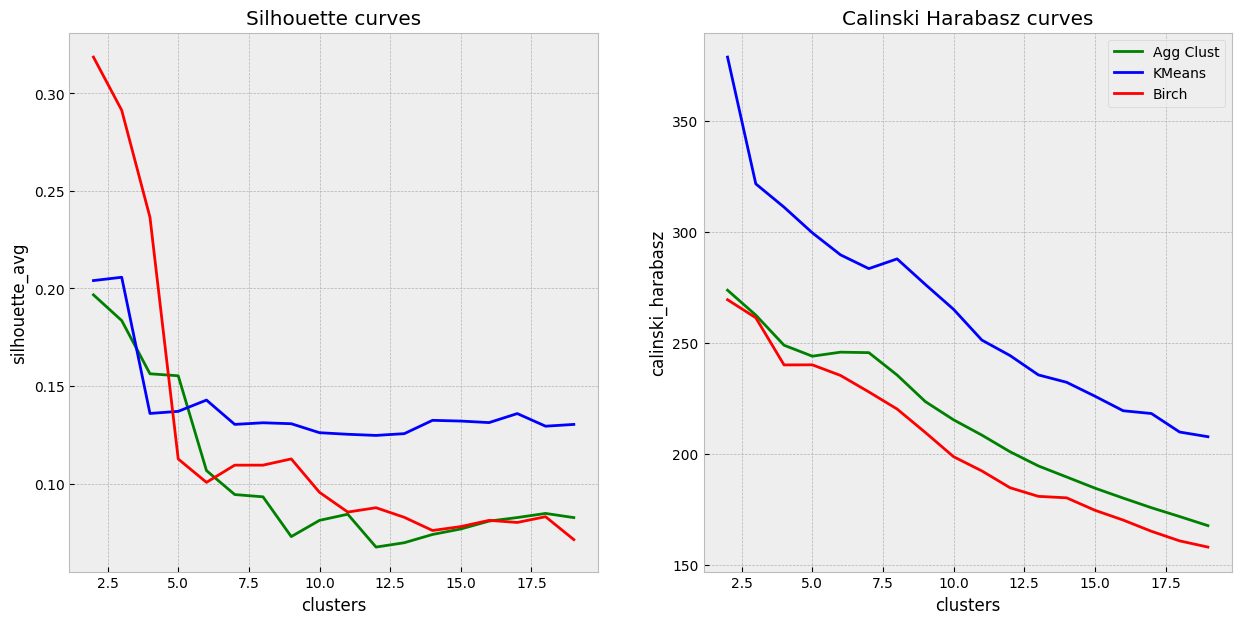

In [ ]:
a = []
X = datasetR.to_numpy(dtype='float')
for ncl in np.arange(2, int(20), 1):
 clusterer = AgglomerativeClustering(n_clusters=int(ncl))
 cluster_labels1 = clusterer.fit_predict(X)
 silhouette_avg1 = silhouette_score(X, cluster_labels1)
 calinski1 = calinski_harabasz_score(X, cluster_labels1)
 clusterer = KMeans(n_clusters=int(ncl))
 with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  cluster_labels2 = clusterer.fit_predict(X)
 silhouette_avg2 = silhouette_score(X, cluster_labels2)
 calinski2 = calinski_harabasz_score(X, cluster_labels2)
 clusterer = Birch(n_clusters=int(ncl))
 cluster_labels3 = clusterer.fit_predict(X)
 silhouette_avg3 = silhouette_score(X, cluster_labels3)
 calinski3 = calinski_harabasz_score(X, cluster_labels3)
 row = pd.DataFrame({"ncl": [ncl],
                     "silAggCl": [silhouette_avg1], "c_hAggCl": [calinski1],
                     "silKMeans": [silhouette_avg2], "c_hKMeans": [calinski2],
                     "silBirch": [silhouette_avg3], "c_hBirch": [calinski3],
                     })
 a.append(row)

scores = pd.concat(a, ignore_index=True)
plt.style.use('bmh')
fig, [ax_sil, ax_ch] = plt.subplots(1,2,figsize=(15,7))
ax_sil.plot(scores["ncl"], scores["silAggCl"], 'g-')
ax_sil.plot(scores["ncl"], scores["silKMeans"], 'b-')
ax_sil.plot(scores["ncl"], scores["silBirch"], 'r-')
ax_ch.plot(scores["ncl"], scores["c_hAggCl"], 'g-', label='Agg Clust')
ax_ch.plot(scores["ncl"], scores["c_hKMeans"], 'b-', label='KMeans')
ax_ch.plot(scores["ncl"], scores["c_hBirch"], 'r-', label='Birch')
ax_sil.set_title("Silhouette curves")
ax_ch.set_title("Calinski Harabasz curves")
ax_sil.set_xlabel('clusters')
ax_sil.set_ylabel('silhouette_avg')
ax_ch.set_xlabel('clusters')
ax_ch.set_ylabel('calinski_harabasz')
ax_ch.legend(loc="upper right")
plt.show()




Then we fix the number of clusters for the algorithms. The diagram is going to help determine how close the clusters are

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


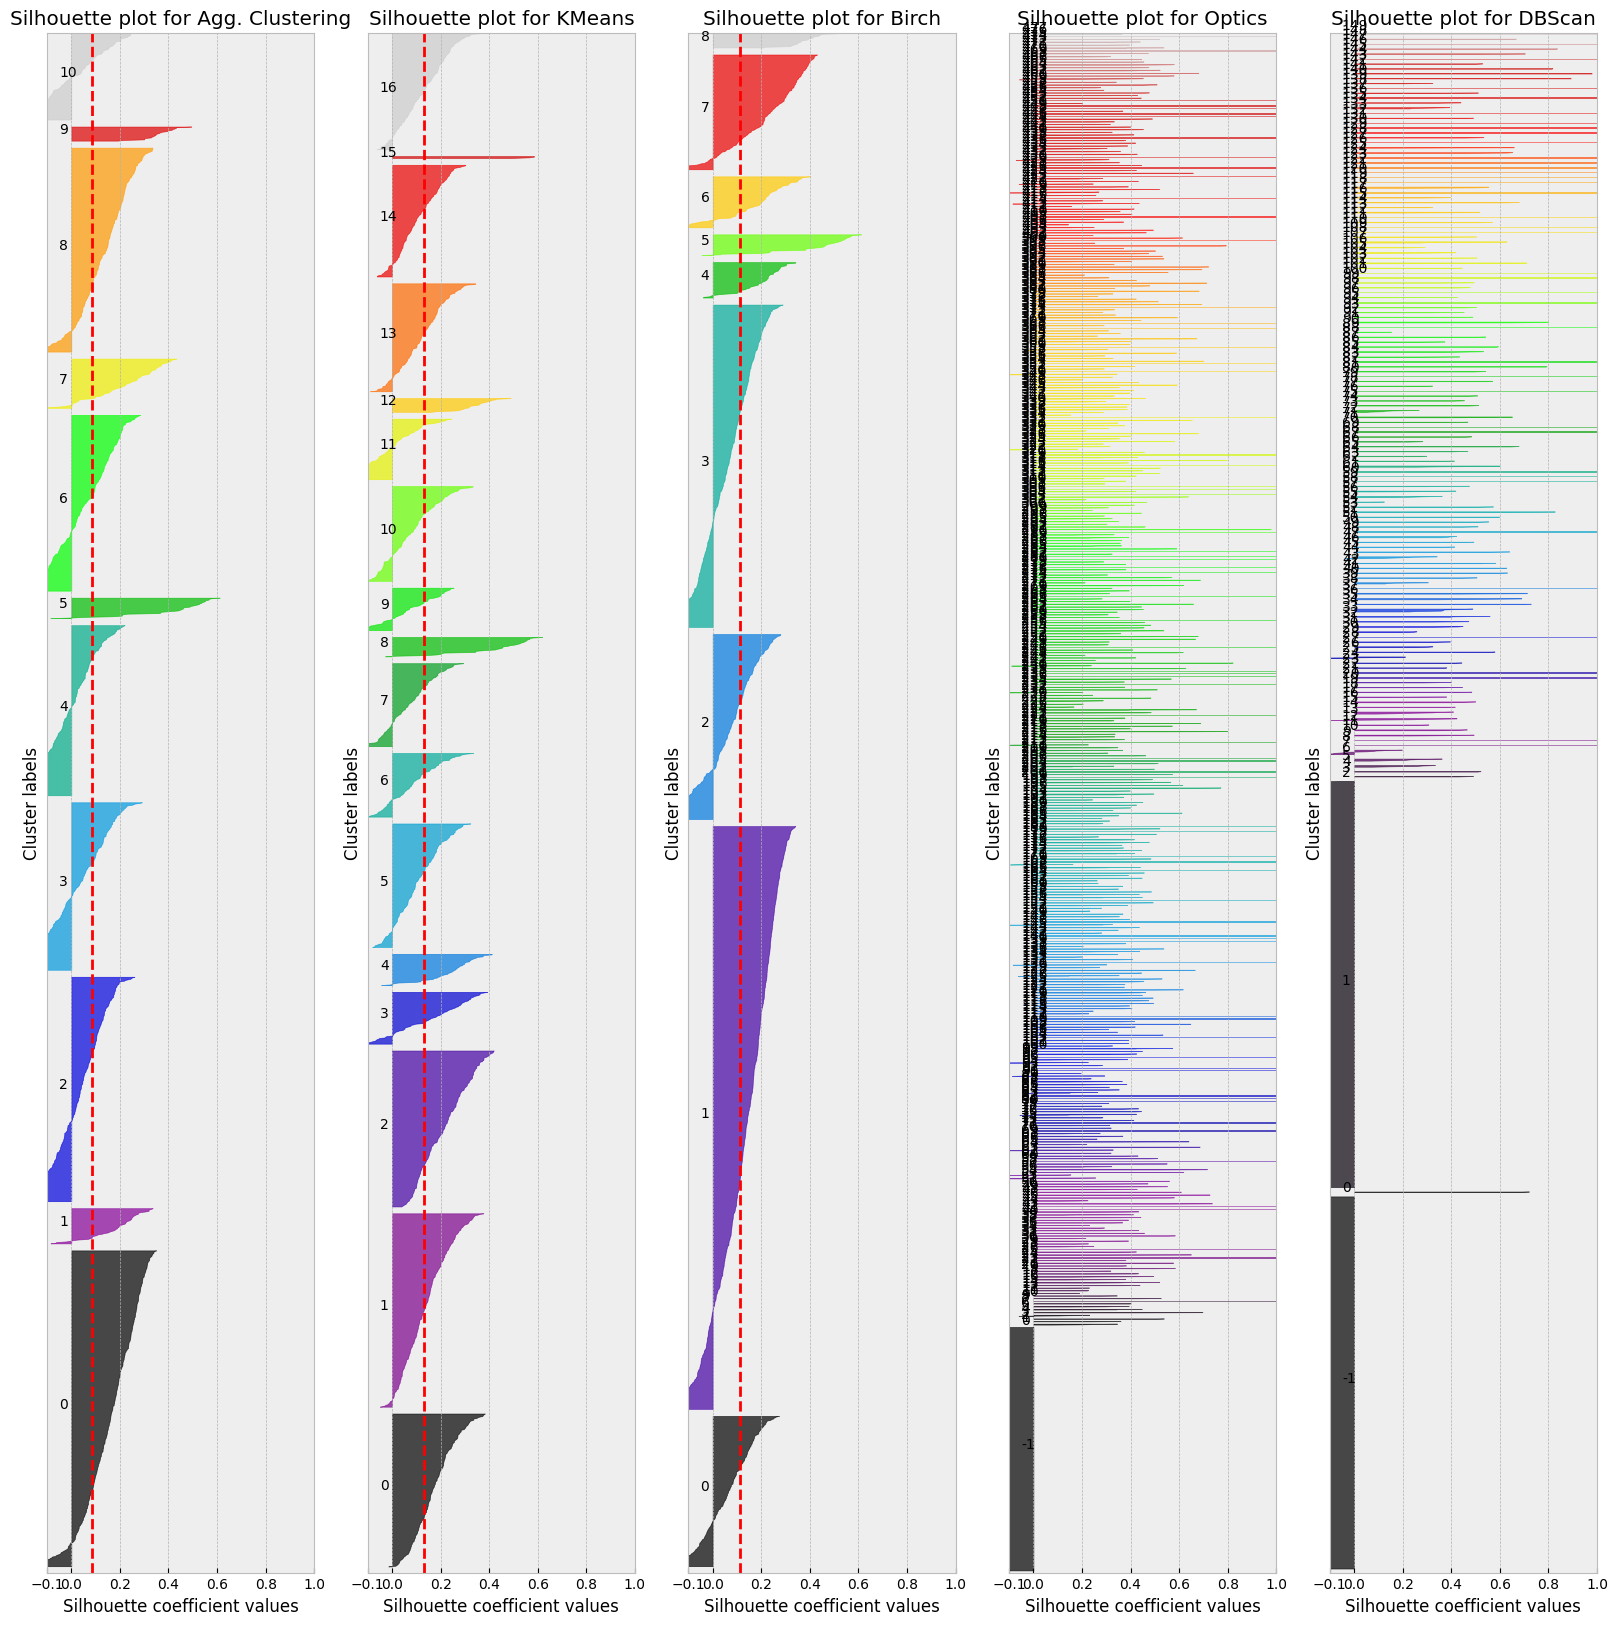

In [ ]:
ncl_AggCl = 11
ncl_KMeans = 17
ncl_Birch = 9

X = datasetR.to_numpy(dtype='float')
clusterer1 = AgglomerativeClustering(n_clusters=int(ncl_AggCl))
cluster_labels1 = clusterer1.fit_predict(X)
n_clusters1 = max(cluster_labels1)
silhouette_avg1 = silhouette_score(X, cluster_labels1)
sample_silhouette_values1 = silhouette_samples(X, cluster_labels1)

with warnings.catch_warnings():
 warnings.simplefilter("ignore")
 clusterer2 = KMeans(n_clusters=int(ncl_KMeans))
 cluster_labels2 = clusterer2.fit_predict(X)
n_clusters2 = max(cluster_labels2)
silhouette_avg2 = silhouette_score(X, cluster_labels2)
sample_silhouette_values2 = silhouette_samples(X, cluster_labels2)

clusterer3 = Birch(n_clusters=int(ncl_Birch))
cluster_labels3 = clusterer3.fit_predict(X)
n_clusters3 = max(cluster_labels3)
silhouette_avg3 = silhouette_score(X, cluster_labels3)
sample_silhouette_values3 = silhouette_samples(X, cluster_labels3)

clusterer4 = OPTICS(min_samples=2)
cluster_labels4 = clusterer4.fit_predict(X)
n_clusters4 = max(cluster_labels4)
silhouette_avg4 = silhouette_score(X, cluster_labels4)
sample_silhouette_values4 = silhouette_samples(X, cluster_labels4)

clusterer5 = DBSCAN(eps=1, min_samples=2)
cluster_labels5 = clusterer5.fit_predict(X)
n_clusters5 = max(cluster_labels5)
silhouette_avg5 = silhouette_score(X, cluster_labels5)
sample_silhouette_values5 = silhouette_samples(X, cluster_labels5)

finalDF = datasetR.copy()
finalDF["clAggCl"] = cluster_labels1
finalDF["clKMeans"] = cluster_labels2
finalDF["clBirch"] = cluster_labels3
finalDF["clOptics"] = cluster_labels4
finalDF["clDbscan"] = cluster_labels5
finalDF["silAggCl"] = sample_silhouette_values1
finalDF["silKMeans"] = sample_silhouette_values2
finalDF["silBirch"] = sample_silhouette_values3
finalDF["silOptics"] = sample_silhouette_values4
finalDF["silDbscan"] = sample_silhouette_values5
finalDFf = pd.merge(finalDF, metadata, left_index=True, right_index=True)
finalDFf['artist_genres'] = finalDFf['artist_genres'].apply(lambda x: ast.literal_eval(x))

fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1,5,figsize=(20,20))
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters1 + 1) * 10])
y_lower = 10
for i in range(min(cluster_labels1),max(cluster_labels1)+1):
 ith_cluster_silhouette_values = sample_silhouette_values1[cluster_labels1 == i]
 ith_cluster_silhouette_values.sort()
 size_cluster_i = ith_cluster_silhouette_values.shape[0]
 y_upper = y_lower + size_cluster_i
 color = cm.nipy_spectral(float(i) / n_clusters1)
 ax1.fill_betweenx(
  np.arange(y_lower, y_upper),
  0,
  ith_cluster_silhouette_values,
  facecolor=color,
  edgecolor=color,
  alpha=0.7,
 )
 ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 y_lower = y_upper + 10  # 10 for the 0 samples
ax1.set_title("Silhouette plot for Agg. Clustering")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster labels")
ax1.axvline(x=silhouette_avg1, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

ax2.set_xlim([-0.1, 1])
ax2.set_ylim([0, len(X) + (n_clusters2 + 1) * 10])
y_lower = 10
for i in range(min(cluster_labels2),max(cluster_labels2)+1):
 ith_cluster_silhouette_values = sample_silhouette_values2[cluster_labels2 == i]
 ith_cluster_silhouette_values.sort()
 size_cluster_i = ith_cluster_silhouette_values.shape[0]
 y_upper = y_lower + size_cluster_i
 color = cm.nipy_spectral(float(i) / n_clusters2)
 ax2.fill_betweenx(
  np.arange(y_lower, y_upper),
  0,
  ith_cluster_silhouette_values,
  facecolor=color,
  edgecolor=color,
  alpha=0.7,
 )
 ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 y_lower = y_upper + 10  # 10 for the 0 samples
ax2.set_title("Silhouette plot for KMeans")
ax2.set_xlabel("Silhouette coefficient values")
ax2.set_ylabel("Cluster labels")
ax2.axvline(x=silhouette_avg2, color="red", linestyle="--")
ax2.set_yticks([])  # Clear the yaxis labels / ticks
ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

ax3.set_xlim([-0.1, 1])
ax3.set_ylim([0, len(X) + (n_clusters3 + 1) * 10])
y_lower = 10
for i in range(min(cluster_labels3),max(cluster_labels3)+1):
 ith_cluster_silhouette_values = sample_silhouette_values3[cluster_labels3 == i]
 ith_cluster_silhouette_values.sort()
 size_cluster_i = ith_cluster_silhouette_values.shape[0]
 y_upper = y_lower + size_cluster_i
 color = cm.nipy_spectral(float(i) / n_clusters3)
 ax3.fill_betweenx(
  np.arange(y_lower, y_upper),
  0,
  ith_cluster_silhouette_values,
  facecolor=color,
  edgecolor=color,
  alpha=0.7,
 )
 ax3.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 y_lower = y_upper + 10  # 10 for the 0 samples
ax3.set_title("Silhouette plot for Birch")
ax3.set_xlabel("Silhouette coefficient values")
ax3.set_ylabel("Cluster labels")
ax3.axvline(x=silhouette_avg3, color="red", linestyle="--")
ax3.set_yticks([])  # Clear the yaxis labels / ticks
ax3.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

ax4.set_xlim([-0.1, 1])
ax4.set_ylim([0, len(X) + (n_clusters4 + 1) * 10])
y_lower = 10
for i in range(min(cluster_labels4),max(cluster_labels4)+1):
 ith_cluster_silhouette_values = sample_silhouette_values4[cluster_labels4 == i]
 ith_cluster_silhouette_values.sort()
 size_cluster_i = ith_cluster_silhouette_values.shape[0]
 y_upper = y_lower + size_cluster_i
 color = cm.nipy_spectral(float(i) / n_clusters4)
 ax4.fill_betweenx(
  np.arange(y_lower, y_upper),
  0,
  ith_cluster_silhouette_values,
  facecolor=color,
  edgecolor=color,
  alpha=0.7,
 )
 ax4.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 y_lower = y_upper + 10  # 10 for the 0 samples
ax4.set_title("Silhouette plot for Optics")
ax4.set_xlabel("Silhouette coefficient values")
ax4.set_ylabel("Cluster labels")
ax4.axvline(x=silhouette_avg4, color="red", linestyle="--")
ax4.set_yticks([])  # Clear the yaxis labels / ticks
ax4.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

ax5.set_xlim([-0.1, 1])
ax5.set_ylim([0, len(X) + (n_clusters5 + 1) * 10])
y_lower = 10
for i in range(min(cluster_labels5),max(cluster_labels5)+1):
 ith_cluster_silhouette_values = sample_silhouette_values5[cluster_labels5 == i]
 ith_cluster_silhouette_values.sort()
 size_cluster_i = ith_cluster_silhouette_values.shape[0]
 y_upper = y_lower + size_cluster_i
 color = cm.nipy_spectral(float(i) / n_clusters5)
 ax5.fill_betweenx(
  np.arange(y_lower, y_upper),
  0,
  ith_cluster_silhouette_values,
  facecolor=color,
  edgecolor=color,
  alpha=0.7,
 )
 ax5.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 y_lower = y_upper + 10  # 10 for the 0 samples
ax5.set_title("Silhouette plot for DBScan")
ax5.set_xlabel("Silhouette coefficient values")
ax5.set_ylabel("Cluster labels")
ax5.axvline(x=silhouette_avg5, color="red", linestyle="--")
ax5.set_yticks([])  # Clear the yaxis labels / ticks
ax5.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


Since I need to select a genre for the next part of the excercise I need first to undo that column, which is a list, but it is writen as text, and I will count the number of words in a genre, to remove the composed ones. This will show the unique values of genres.

In [ ]:
finalDFf = pd.merge(finalDF, metadata, left_index=True, right_index=True)
finalDFf['artist_genres'] = finalDFf['artist_genres'].apply(lambda x: ast.literal_eval(x))
genres = pd.DataFrame(finalDFf['artist_genres'].explode())
finalDFgen = pd.merge(finalDF, genres, left_index=True, right_index=True)
finalDFgen = finalDFgen.drop_duplicates()
genrestbl = pd.DataFrame(finalDFgen.groupby('artist_genres')['artist_genres'].count()).reset_index(names="genre").sort_values(['artist_genres'], ascending=False)
print(genrestbl.head(100).to_string())

                          genre  artist_genres
314                         pop            935
112                   dance pop            513
340                         rap            363
322                     pop rap            291
198                     hip hop            239
337                         r&b            226
422          urban contemporary            208
404                        trap            129
387            southern hip hop            125
352                        rock            123
268                 modern rock            120
73                 canadian pop            107
138                         edm            106
200                     hip pop             96
315                   pop dance             87
19                  atl hip hop             85
171                gangster rap             80
327                 post-grunge             78
273                  neo mellow             78
419                      uk pop             77
323          

List of genres to select on the next section

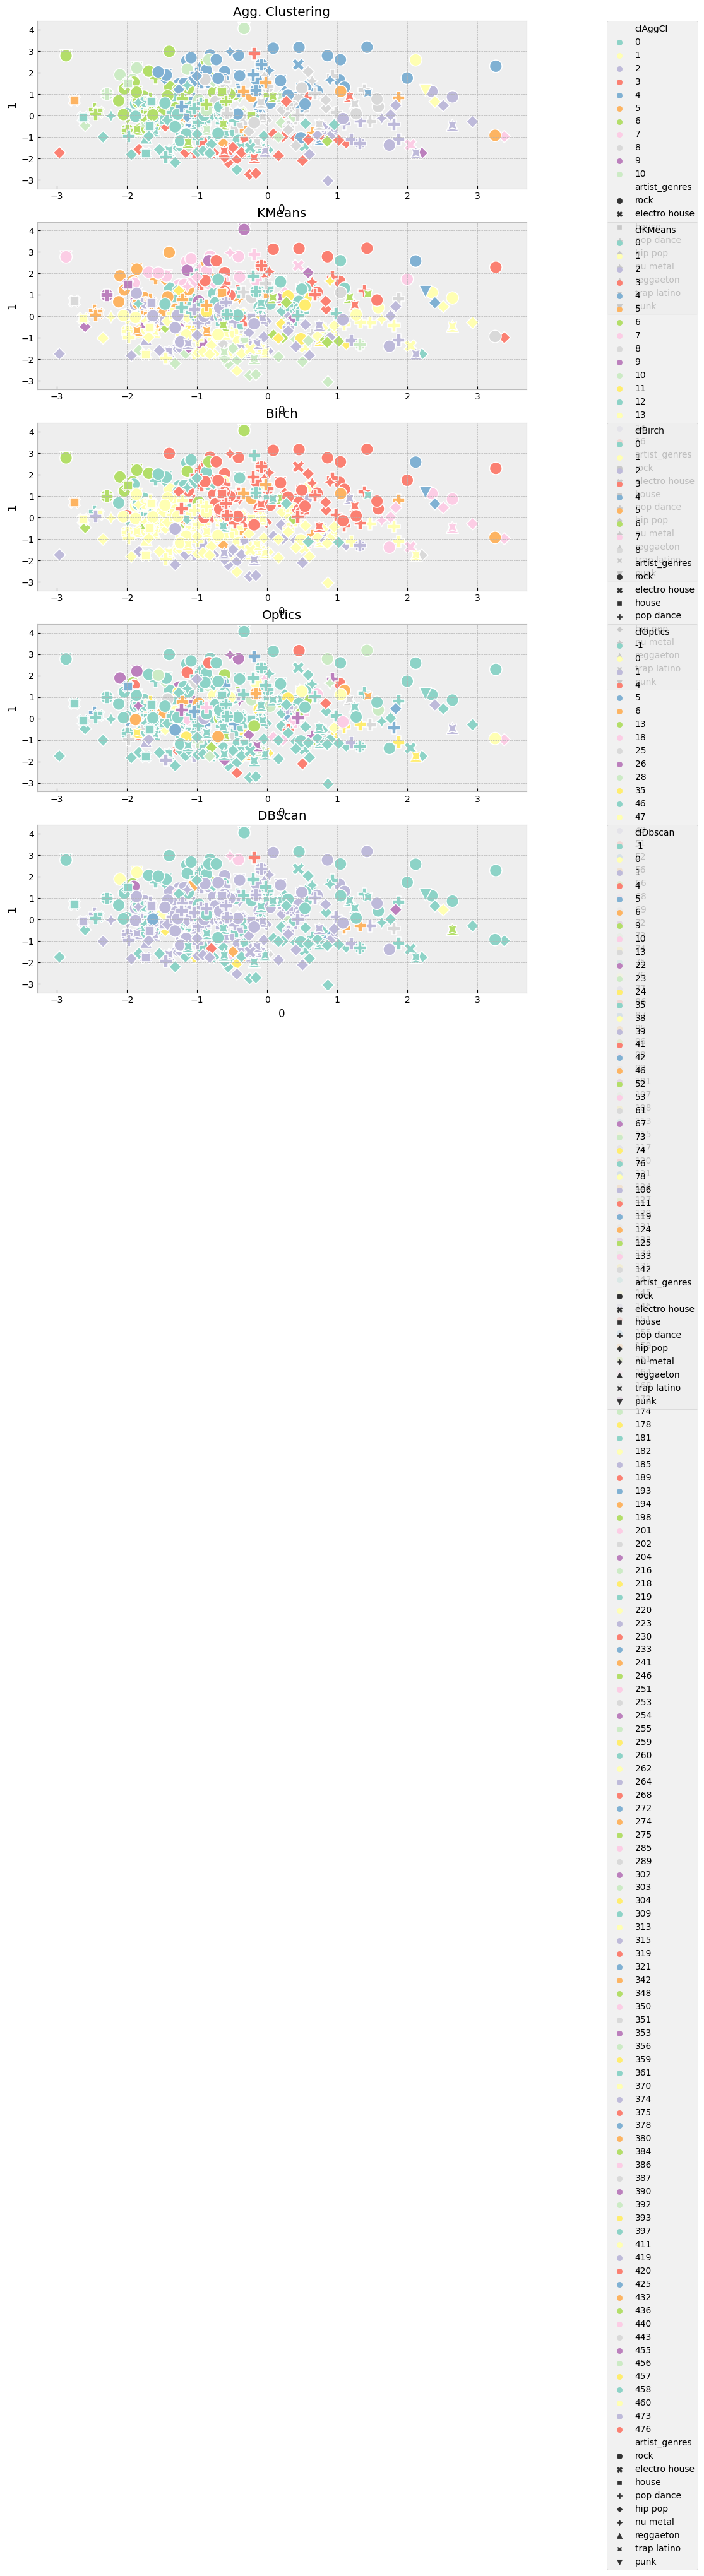

In [ ]:
selectedgenres = ['rock','reggaeton','house','hip pop','electro house','trap latino', 'punk', 'nu metal', 'pop dance']
filtered = finalDFgen[finalDFgen['artist_genres'].isin(selectedgenres)]
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5,1, figsize=(10,20))
sns.scatterplot(data=filtered, x="0", y="1", hue="clAggCl", style="artist_genres",s = 200, alpha = 1, palette="Set3", ax=ax1)
sns.scatterplot(data=filtered, x="0", y="1", hue="clKMeans", style="artist_genres",s = 200, alpha = 1, palette="Set3", ax=ax2)
sns.scatterplot(data=filtered, x="0", y="1", hue="clBirch", style="artist_genres",s = 200, alpha = 1, palette="Set3", ax=ax3)
sns.scatterplot(data=filtered, x="0", y="1", hue="clOptics", style="artist_genres",s = 200, alpha = 1, palette="Set3", ax=ax4)
sns.scatterplot(data=filtered, x="0", y="1", hue="clDbscan", style="artist_genres",s = 200, alpha = 1, palette="Set3", ax=ax5)
ax1.set_title("Agg. Clustering")
ax2.set_title("KMeans")
ax3.set_title("Birch")
ax4.set_title("Optics")
ax5.set_title("DBScan")
ax1.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax2.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax3.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax4.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax5.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)

Heatmap between genre and clusters

Text(0.5, 1.0, 'DBScan')

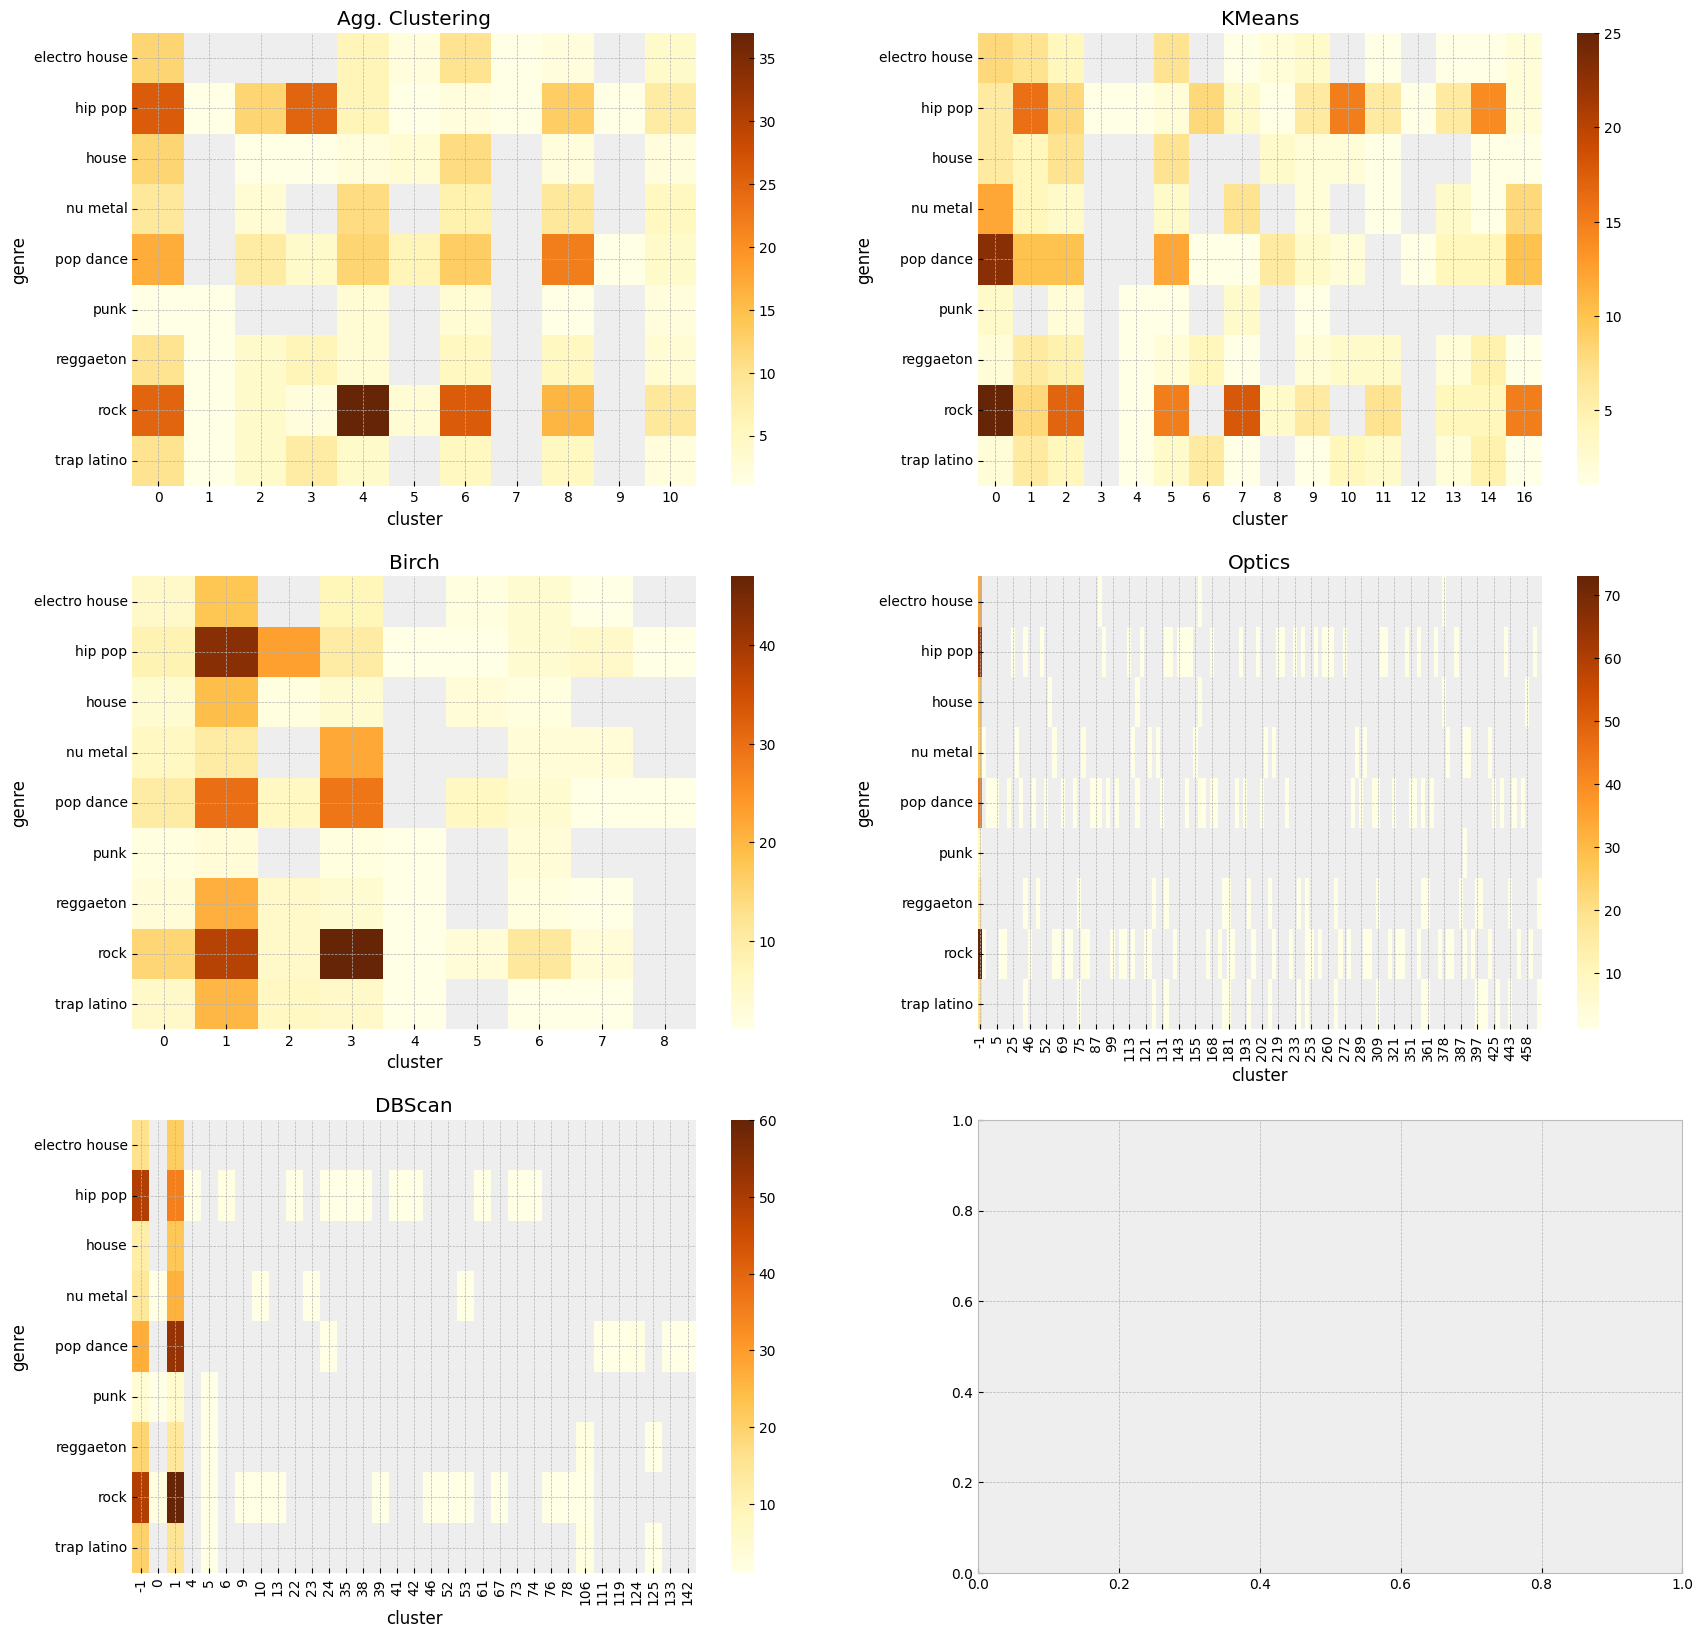

In [ ]:
artistheatAggCl = pd.DataFrame(filtered.groupby(['artist_genres','clAggCl'])['artist_genres'].count()).reset_index(names=["genre","cluster"])
artistheatAggCl = artistheatAggCl.pivot(index="genre", columns="cluster", values="artist_genres")

artistheatKMeans = pd.DataFrame(filtered.groupby(['artist_genres','clKMeans'])['artist_genres'].count()).reset_index(names=["genre","cluster"])
artistheatKMeans = artistheatKMeans.pivot(index="genre", columns="cluster", values="artist_genres")

artistheatBirch = pd.DataFrame(filtered.groupby(['artist_genres','clBirch'])['artist_genres'].count()).reset_index(names=["genre","cluster"])
artistheatBirch = artistheatBirch.pivot(index="genre", columns="cluster", values="artist_genres")

artistheatOptics = pd.DataFrame(filtered.groupby(['artist_genres','clOptics'])['artist_genres'].count()).reset_index(names=["genre","cluster"])
artistheatOptics = artistheatOptics.pivot(index="genre", columns="cluster", values="artist_genres")

artistheatDbscan = pd.DataFrame(filtered.groupby(['artist_genres','clDbscan'])['artist_genres'].count()).reset_index(names=["genre","cluster"])
artistheatDbscan = artistheatDbscan.pivot(index="genre", columns="cluster", values="artist_genres")

fig, axes = plt.subplots(3,2, figsize=(20,20))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
sns.heatmap(artistheatAggCl, cmap="YlOrBr", ax=ax1)
sns.heatmap(artistheatKMeans, cmap="YlOrBr", ax=ax2)
sns.heatmap(artistheatBirch, cmap="YlOrBr", ax=ax3)
sns.heatmap(artistheatOptics, cmap="YlOrBr", ax=ax4)
sns.heatmap(artistheatDbscan, cmap="YlOrBr", ax=ax5)
ax1.set_title("Agg. Clustering")
ax2.set_title("KMeans")
ax3.set_title("Birch")
ax4.set_title("Optics")
ax5.set_title("DBScan")

It is possible to do the same exploration by artist instead

In [ ]:
artisttbl = pd.DataFrame(finalDFf.groupby('artist_name')['artist_name'].count()).reset_index(names="artist").sort_values(['artist_name'], ascending=False)
print(artisttbl.head(100).to_string())

                       artist  artist_name
219                     Drake           36
665                   Rihanna           33
763              Taylor Swift           33
52              Ariana Grande           26
396             Justin Bieber           25
162                  Coldplay           22
90                   BeyoncÃ©           22
613                      P!nk           22
22                      Adele           21
227                Ed Sheeran           21
93              Billie Eilish           21
126             Calvin Harris           21
407                Kanye West           20
642               Post Malone           19
238                    Eminem           18
151               Chris Brown           18
113                Bruno Mars           17
412                Katy Perry           17
362              Jason Derulo           16
96            Black Eyed Peas           16
805                The Weeknd           15
112            Britney Spears           15
220        

We selected the artists to explore

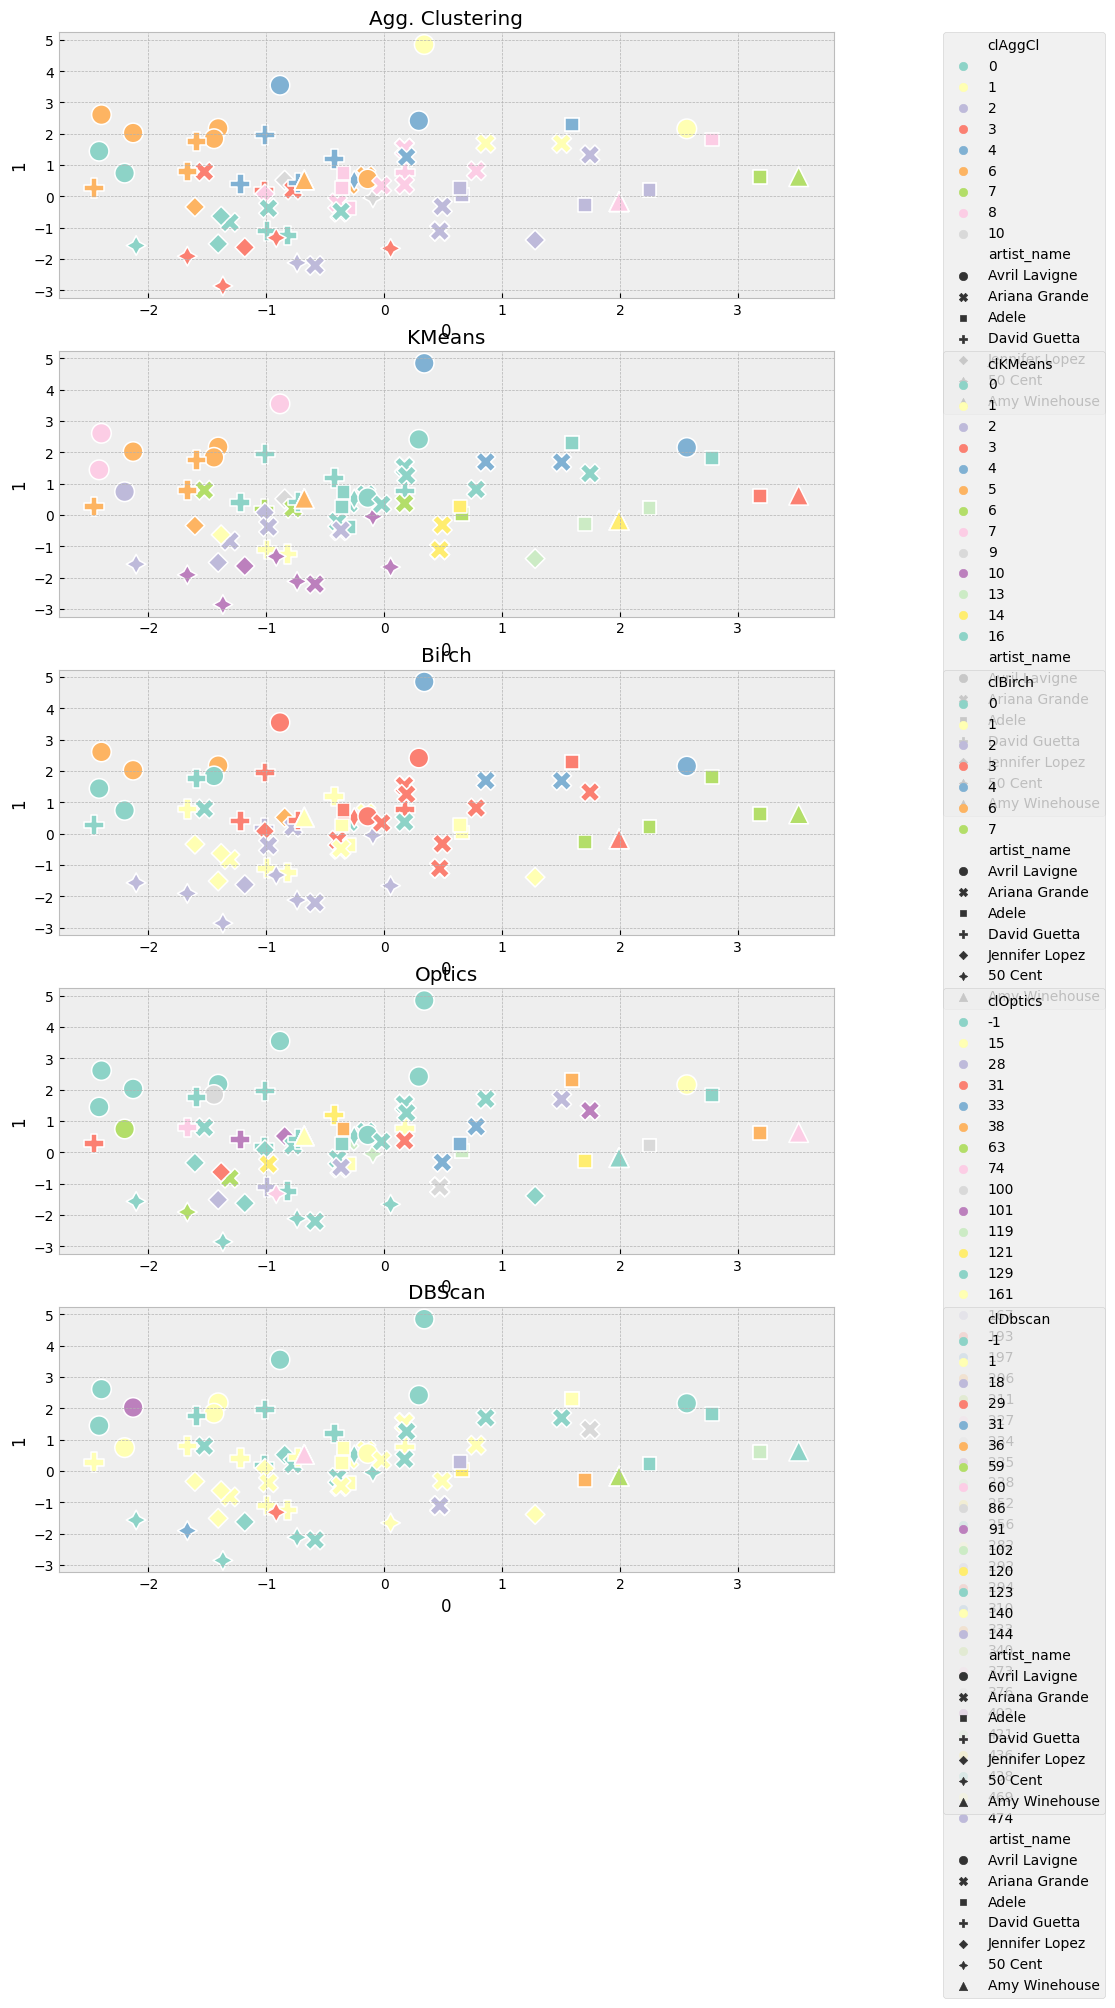

In [ ]:
selectedartists = ['Jennifer Lopez','50 Cent','Avril Lavigne','Ariana Grande','David Guetta','Adele','Amy Winehouse']
filtered = finalDFf[finalDFf['artist_name'].isin(selectedartists)]
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5,1, figsize=(10,20))
sns.scatterplot(data=filtered, x="0", y="1", hue="clAggCl", style="artist_name",s = 200, alpha = 1, palette="Set3", ax=ax1)
sns.scatterplot(data=filtered, x="0", y="1", hue="clKMeans", style="artist_name",s = 200, alpha = 1, palette="Set3", ax=ax2)
sns.scatterplot(data=filtered, x="0", y="1", hue="clBirch", style="artist_name",s = 200, alpha = 1, palette="Set3", ax=ax3)
sns.scatterplot(data=filtered, x="0", y="1", hue="clOptics", style="artist_name",s = 200, alpha = 1, palette="Set3", ax=ax4)
sns.scatterplot(data=filtered, x="0", y="1", hue="clDbscan", style="artist_name",s = 200, alpha = 1, palette="Set3", ax=ax5)
ax1.set_title("Agg. Clustering")
ax2.set_title("KMeans")
ax3.set_title("Birch")
ax4.set_title("Optics")
ax5.set_title("DBScan")
ax1.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax2.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax3.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax4.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)
ax5.legend(bbox_to_anchor=(1.35, 1), borderaxespad=0)

Heatmap between artist and clusters

Text(0.5, 1.0, 'DBScan')

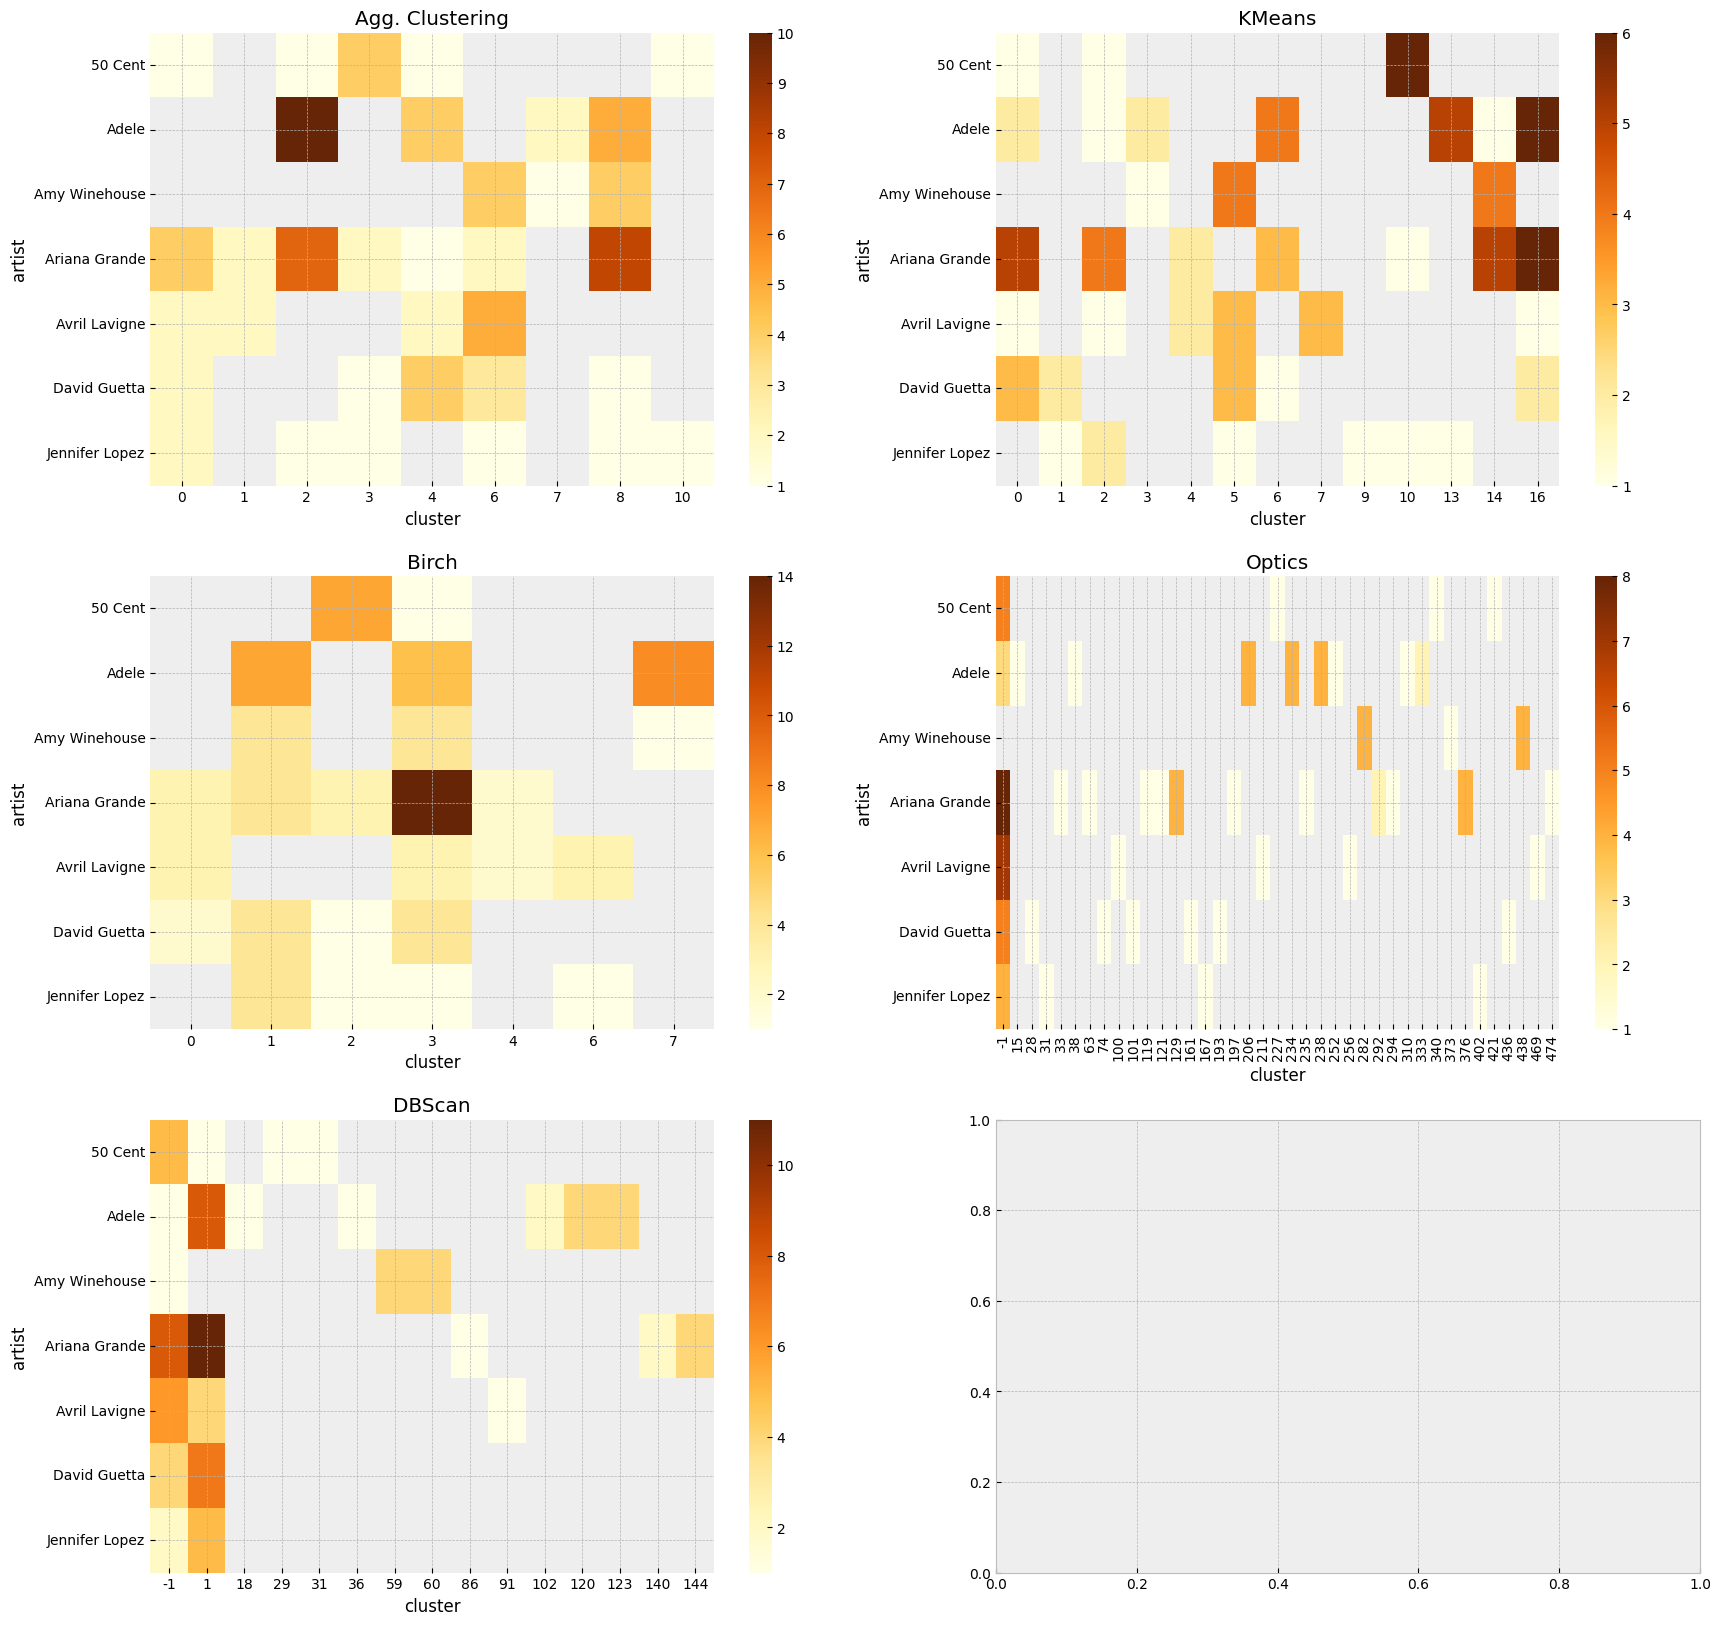

In [ ]:
artistheatAggCl = pd.DataFrame(filtered.groupby(['artist_name','clAggCl'])['artist_name'].count()).reset_index(names=["artist","cluster"])
artistheatAggCl = artistheatAggCl.pivot(index="artist", columns="cluster", values="artist_name")

artistheatKMeans = pd.DataFrame(filtered.groupby(['artist_name','clKMeans'])['artist_name'].count()).reset_index(names=["artist","cluster"])
artistheatKMeans = artistheatKMeans.pivot(index="artist", columns="cluster", values="artist_name")

artistheatBirch = pd.DataFrame(filtered.groupby(['artist_name','clBirch'])['artist_name'].count()).reset_index(names=["artist","cluster"])
artistheatBirch = artistheatBirch.pivot(index="artist", columns="cluster", values="artist_name")

artistheatOptics = pd.DataFrame(filtered.groupby(['artist_name','clOptics'])['artist_name'].count()).reset_index(names=["artist","cluster"])
artistheatOptics = artistheatOptics.pivot(index="artist", columns="cluster", values="artist_name")

artistheatDbscan = pd.DataFrame(filtered.groupby(['artist_name','clDbscan'])['artist_name'].count()).reset_index(names=["artist","cluster"])
artistheatDbscan = artistheatDbscan.pivot(index="artist", columns="cluster", values="artist_name")

fig, axes = plt.subplots(3,2, figsize=(20,20))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
sns.heatmap(artistheatAggCl, cmap="YlOrBr", ax=ax1)
sns.heatmap(artistheatKMeans, cmap="YlOrBr", ax=ax2)
sns.heatmap(artistheatBirch, cmap="YlOrBr", ax=ax3)
sns.heatmap(artistheatOptics, cmap="YlOrBr", ax=ax4)
sns.heatmap(artistheatDbscan, cmap="YlOrBr", ax=ax5)
ax1.set_title("Agg. Clustering")
ax2.set_title("KMeans")
ax3.set_title("Birch")
ax4.set_title("Optics")
ax5.set_title("DBScan")